# Tensorflow Tutorial

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import PIL
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
data_url="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir=tf.keras.utils.get_file('flower_photos', origin=data_url, untar=True)
data_dir=pathlib.Path(data_dir)

+ pathlib :파일 시스템을 문자열이 아닌 객체로 다룸(문자열을 WindowPath로)
    + `data_dir`: 'C:\\Users\\hnn02\\.keras\\datasets\\flower_photos'
    + `pathlib.path(data_dir)` : WindowsPath('C:/Users/hnn02/.keras/datasets/flower_photos')

In [4]:
image_count=len(list(data_dir.glob("*/*.jpg")))
print(image_count)

3670


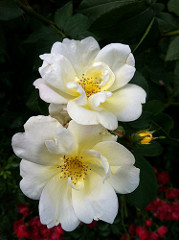

In [5]:
rose=list(data_dir.glob("roses/*"))
PIL.Image.open(str(rose[0]))

+ 이미지 파일 불러오기 위해 다시 객체를 문자열로 변환
    + `rose[0]`: WindowsPath('C:/Users/hnn02/.keras/datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg')
    + `str(rose[0])`: 'C:\\Users\\hnn02\\.keras\\datasets\\flower_photos\\roses\\10090824183_d02c613f10_m.jpg'

In [5]:
batch_size=32
img_width=180
img_height=180

+ `tf.keras.preprocessing`이 아닌 `tf.data`를 이용하여 데이터를 불러옴

In [6]:
list_ds=tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds=list_ds.shuffle(image_count, reshuffle_each_iteration=False)

+ `reshuffle_each_iteration`: shuffle한 데이터셋이 호출될때마다 데이터셋 shuffle
    + False로 설정된 데이터를 Train과 Validation 데이터로 나누고 각각 shuffle을 시킬 때 True로 설정하면 True를 따른다.
    + True로 설정된 데이터를 위와 같이 나누고 shuffle 시킬 때 True, False 관계 없이 항상 True

In [7]:
list_ds

<ShuffleDataset shapes: (), types: tf.string>

In [7]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\hnn02\\.keras\\datasets\\flower_photos\\roses\\13279526615_a3b0059bec.jpg'
b'C:\\Users\\hnn02\\.keras\\datasets\\flower_photos\\dandelion\\7243478942_30bf542a2d_m.jpg'
b'C:\\Users\\hnn02\\.keras\\datasets\\flower_photos\\sunflowers\\15118243470_7e0a7f159c_n.jpg'
b'C:\\Users\\hnn02\\.keras\\datasets\\flower_photos\\daisy\\4610018126_21f438d2dc_m.jpg'
b'C:\\Users\\hnn02\\.keras\\datasets\\flower_photos\\sunflowers\\4626721387_88f89d5cc9_n.jpg'


In [8]:
# Label 값
class_names=np.array(sorted([item.name for item in data_dir.glob('*') if item.name!="LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [9]:
# Train 과 Validation 데이터로 split
val_size=int(image_count*0.2)
train_ds=list_ds.skip(val_size)
val_ds=list_ds.take(val_size)

In [10]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [11]:
def get_label(file_path):
    parts=tf.strings.split(file_path, os.path.sep)
    one_hot=parts[-2]==class_names
    return tf.argmax(one_hot)

def decode_img(img):
    img=tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label=get_label(file_path)
    img=tf.io.read_file(file_path)
    img=decode_img(img)
    return img, label

In [12]:
AUTOTUNE=tf.data.experimental.AUTOTUNE

train_ds=train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds=val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print(image.numpy().shape)
    print(label.numpy())

(180, 180, 3)
3


In [14]:
def configure_for_performance(ds):
    ds=ds.cache()
    ds=ds.batch(batch_size)
    ds=ds.shuffle(buffer_size=1000)
    ds=ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds=configure_for_performance(train_ds)
val_ds=configure_for_performance(val_ds)

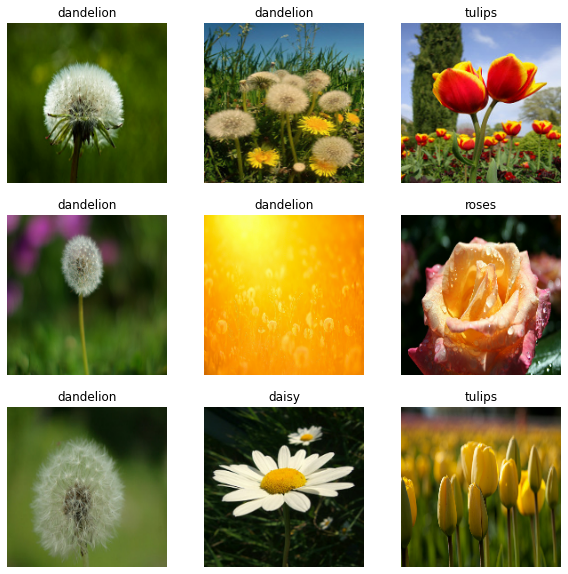

In [15]:
image, label=next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax=plt.subplot(3, 3, i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])
    plt.axis("off")

In [17]:
normalization_layer=layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds=train_ds.map(lambda x, y:(normalization_layer(x), y))

In [21]:
num_classes=5

model=Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [24]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)       

In [26]:
epochs=10
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 2s 27ms/step - loss: 1.2310 - accuracy: 0.4639 - val_loss: 1.0918 - val_accuracy: 0.5695
Epoch 2/10
92/92 [==============================] - 2s 19ms/step - loss: 0.9270 - accuracy: 0.6349 - val_loss: 0.9915 - val_accuracy: 0.5954
Epoch 3/10
92/92 [==============================] - 2s 18ms/step - loss: 0.7191 - accuracy: 0.7302 - val_loss: 1.0364 - val_accuracy: 0.6090
Epoch 4/10
92/92 [==============================] - 2s 19ms/step - loss: 0.5381 - accuracy: 0.8045 - val_loss: 0.9816 - val_accuracy: 0.6308
Epoch 5/10
92/92 [==============================] - 2s 19ms/step - loss: 0.3480 - accuracy: 0.8835 - val_loss: 1.1381 - val_accuracy: 0.6226
Epoch 6/10
92/92 [==============================] - 2s 18ms/step - loss: 0.1990 - accuracy: 0.9380 - val_loss: 1.3248 - val_accuracy: 0.6390
Epoch 7/10
92/92 [==============================] - 2s 19ms/step - loss: 0.1067 - accuracy: 0.9680 - val_loss: 1.3575 - val_accuracy: 0.6580
Epoch 8/10
92

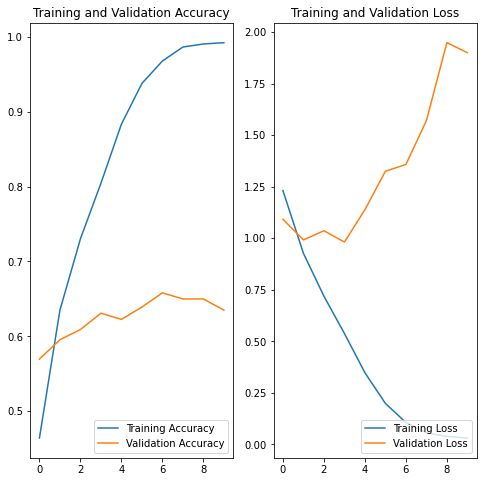

In [27]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range=range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
data_augmentation=keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

+ Overfitting 방지를 위한 Data Augmentation

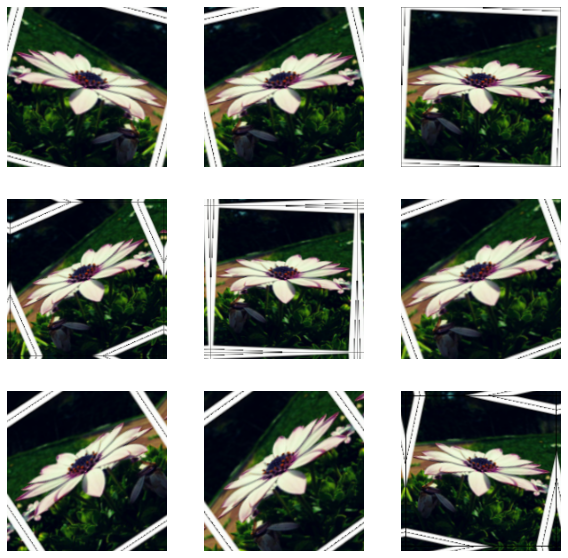

In [33]:
plt.figure(figsize=(10, 10))

for images, label in train_ds.take(1):
    for i in range(9):
        augmented_images=data_augmentation(images)
        ax=plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis("off")

In [34]:
model=Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [38]:
epochs=15
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 2s 22ms/step - loss: 1.2566 - accuracy: 0.4619 - val_loss: 1.1375 - val_accuracy: 0.5654
Epoch 2/15
92/92 [==============================] - 2s 22ms/step - loss: 1.0148 - accuracy: 0.6022 - val_loss: 1.0260 - val_accuracy: 0.5981
Epoch 3/15
92/92 [==============================] - 2s 21ms/step - loss: 0.9046 - accuracy: 0.6529 - val_loss: 0.9412 - val_accuracy: 0.6349
Epoch 4/15
92/92 [==============================] - 2s 22ms/step - loss: 0.8516 - accuracy: 0.6700 - val_loss: 0.8971 - val_accuracy: 0.6608
Epoch 5/15
92/92 [==============================] - 2s 22ms/step - loss: 0.7809 - accuracy: 0.7081 - val_loss: 0.9359 - val_accuracy: 0.6594
Epoch 6/15
92/92 [==============================] - 2s 22ms/step - loss: 0.7481 - accuracy: 0.7146 - val_loss: 0.8440 - val_accuracy: 0.6785
Epoch 7/15
92/92 [==============================] - 2s 21ms/step - loss: 0.7188 - accuracy: 0.7207 - val_loss: 0.8161 - val_accuracy: 0.7003
Epoch 8/15
92

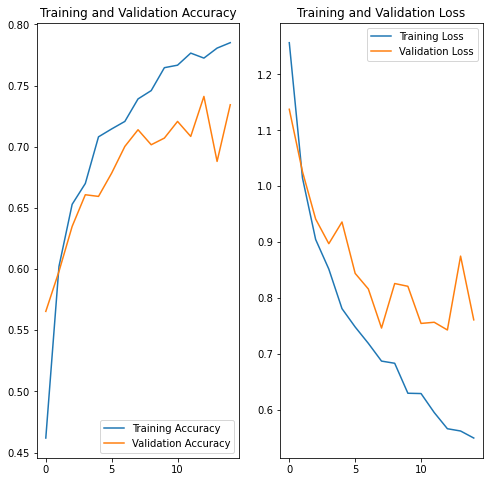

In [40]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]

loss=history.history["loss"]
val_loss=history.history["val_loss"]

epochs_range=range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [51]:
sunflower_url="https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path=tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)


img=keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)

img_array=keras.preprocessing.image.img_to_array(img)
img_array=tf.expand_dims(img_array, 0)

predictions=model.predict(img_array)
score=tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 99.42 percent confidence.
